# 🎨🌞 Albedo Experiment

### Originally created by Dr. A. Denvil-Sommer (NCAS, Univerity of Reading).

## 🌊 Ocean Albedo and Climate Sensitivity

The surface albedo of the global ocean is a critical factor in Earth’s climate system. Even small changes in ocean albedo can significantly alter the global energy budget, which in turn impacts atmospheric circulation, ocean currents, and the hydrological cycle.

Typical ocean albedo values range from 0.06 to 0.10, with lower values near the equator and slightly higher values near the poles due to changes in sun angle and surface roughness.

## 🎯 Objective

Investigate how increasing ocean **albedo (reflectivity)** affects surface temperature and the atmosphere when coupled with land and ocean models in SpeedyWeather.jl.

## 🌊🧪 Ocean Albedo Experiment Setup
We will explore how changes in ocean albedo affect the atmosphere by comparing two simulations:

**🔹 Control Run (Realistic Albedo)**

Although ocean albedo typically varies with latitude, as mentioned above, for the sake of model stability in our control run, we prescribe a uniform ocean albedo of `0.06` across all latitudes.

**🔸 Perturbed Run (High Albedo)**

Now increase the ocean albedo uniformly to examine its impact: `0.16` 

⚠️ Important: Save each simulation to a separate folder or give output files unique names, so you can easily compare results later without overwriting.

## 🔬 🧠 Guiding Questions

- How did the surface temperature respond to increased ocean albedo?

- Do the equator-to-pole temperature gradients change?

- Is there a noticeable impact on precipitation patterns?

- How do atmospheric circulation fields (e.g., zonal wind) respond?

- Can you relate these effects to Earth’s climate sensitivity or feedbacks?

## 💾 Variables to Invistigate 

To investigate the effects of ocean albedo changes, you should save the following variables from your simulation output:

- **🌊 Sea Surface Temperature (SST)**
`simulation.prognostic_variables.ocean.sea_surface_temperature`

- **💧 Specific Humidity**
`simulation.diagnostic_variables.grid.humid_grid`

- **🌬️ Surface Winds (Zonal and Meridional)**
`simulation.diagnostic_variables.grid.u_grid`
`simulation.diagnostic_variables.grid.v_grid`

- **🌧️ Precipitation (Large-scale)**
`simulation.diagnostic_variables.physics.precip_large_scale`

- **📉 Pressure Tendency (for Hadley Cell analysis)**
`simulation.diagnostic_variables.tendencies.pres_tend`

👉 You may also consider saving additional variables depending on the focus of your analysis.

In [1]:
using SpeedyWeather
using Dates
using CairoMakie

In [2]:
# 1. Define the grid and components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="./", id="Climate_Ocean_Albedo", output_dt=Minute(360))

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 21600 seconds
└┐ variables:
 ├ v: meridional wind [m/s]
 ├ humid: specific humidity [kg/kg]
 ├ temp: temperature [degC]
 ├ u: zonal wind [m/s]
 ├ pres: surface pressure [hPa]
 └ vor: relative vorticity [s^-1]

In [3]:
# 2. Some parameterisation choices
vertical_advection = WENOVerticalAdvection(spectral_grid)

WENOVerticalAdvection{Float32}()

In [7]:
# 3. Set up albedo component
#control run:
#albedo = Albedo(ocean=OceanSeaIceAlbedo(spectral_grid), land=AlbedoClimatology(spectral_grid))

#perturbed run
albedo = Albedo(ocean=OceanSeaIceAlbedo(spectral_grid, albedo_ocean=0.16), land=AlbedoClimatology(spectral_grid))
# albedo = Albedo(GlobalConstantAlbedo(spectral_grid, albedo=0.06), AlbedoClimatology(spectral_grid))

Albedo <: SpeedyWeather.AbstractAlbedo
├ ocean: OceanSeaIceAlbedo{Float32}
└ land: AlbedoClimatology{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}

In [8]:
# create model, initialize, run
### Entirely new run
model = PrimitiveWetModel(spectral_grid; vertical_advection, albedo, output)

simulation = initialize!(model)
# now offset via set! with add=true
set!(albedo.land, (λ, φ) -> 0.1, add=true)

3168-element, 48-ring OctahedralGaussianField{Float32, 1} as Array on CPU
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 0.16982421f0
 ⋮
 0.5804688f0
 0.57851565f0
 0.57851565f0
 0.57851565f0
 0.57851565f0
 0.57851565f0
 0.5804688f0
 0.5804688f0
 0.5804688f0
 0.5804688f0
 0.5804688f0
 0.5804688f0

In [9]:
model.land.geometry

2-layer LandGeometry{Float32, Vector{Float32}}
└ layer_thickness: Float32[0.2, 2.0]

In [13]:
# output both SST and sea ice concentration
add!(model, SpeedyWeather.OceanOutput()...)
add!(model, SpeedyWeather.LandOutput()...)
add!(model, SpeedyWeather.RadiationOutput()...)
add!(model, SpeedyWeather.PrecipitationOutput()...)
add!(model, SpeedyWeather.SurfaceFluxesOutput()...)
#orography
add!(model, SpeedyWeather.BoundaryOutput()...)

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 21600 seconds
└┐ variables:
 ├ snow_cond: accumulated large-scale snow [mm]
 ├ sma: soil moisture availability [1]
 ├ slf: Surface latent heat flux (positive up) [W/m^2]
 ├ rain_conv: accumulated convective rain [mm]
 ├ sru: Surface shortwave radiation up [W/m^2]
 ├ rain_cond: accumulated large-scale rain [mm]
 ├ lsm: land-sea mask (1=land, 0=sea) [1]
 ├ st: soil temperature [degC]
 ├ temp: temper

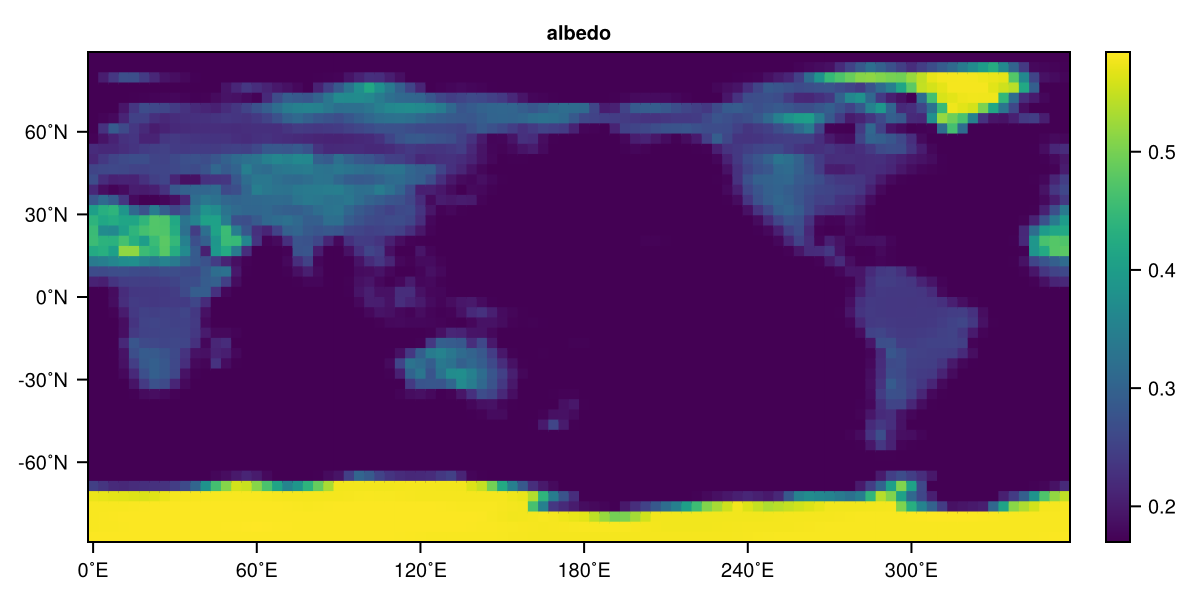

In [11]:
# visualise intial land albedo
alb = simulation.model.albedo.land.albedo
heatmap(alb, title="albedo")

In [12]:
simulation.model.albedo.ocean

OceanSeaIceAlbedo{Float32} <: SpeedyWeather.AbstractAlbedo
├ albedo_ocean::Float32 = 0.16
└ albedo_ice::Float32 = 0.6

In [14]:
# run the simualtion
run!(simulation, period=Year(30), output=true)

Weather is speedy: run_Climate_Ocean_Albedo_0001 100% Time: 5:01:44 (143.17 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

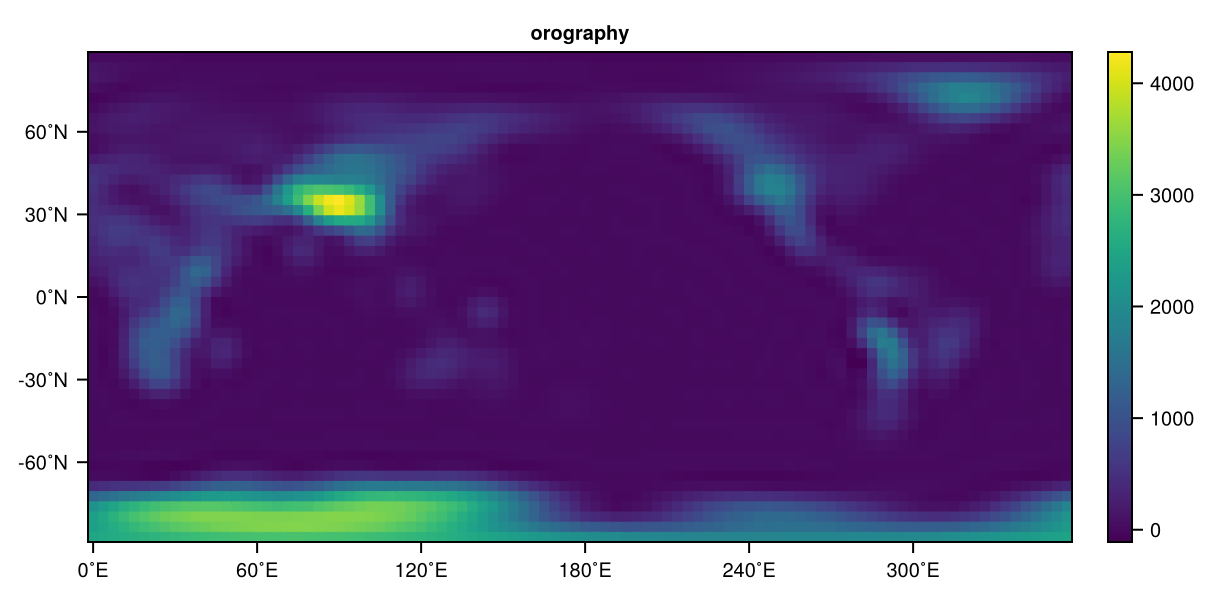

In [15]:
or = simulation.model.orography.orography
heatmap(or, title="orography")

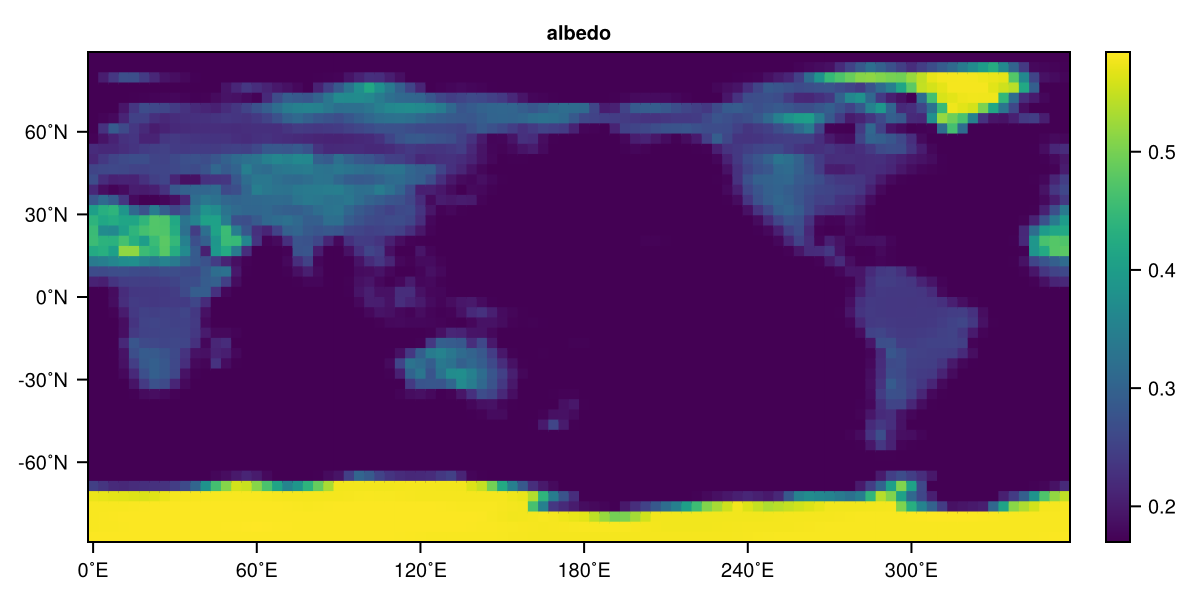

In [16]:
alb = simulation.model.albedo.land.albedo
heatmap(alb, title="albedo")

In [17]:
simulation.model.albedo.ocean

OceanSeaIceAlbedo{Float32} <: SpeedyWeather.AbstractAlbedo
├ albedo_ocean::Float32 = 0.16
└ albedo_ice::Float32 = 0.6

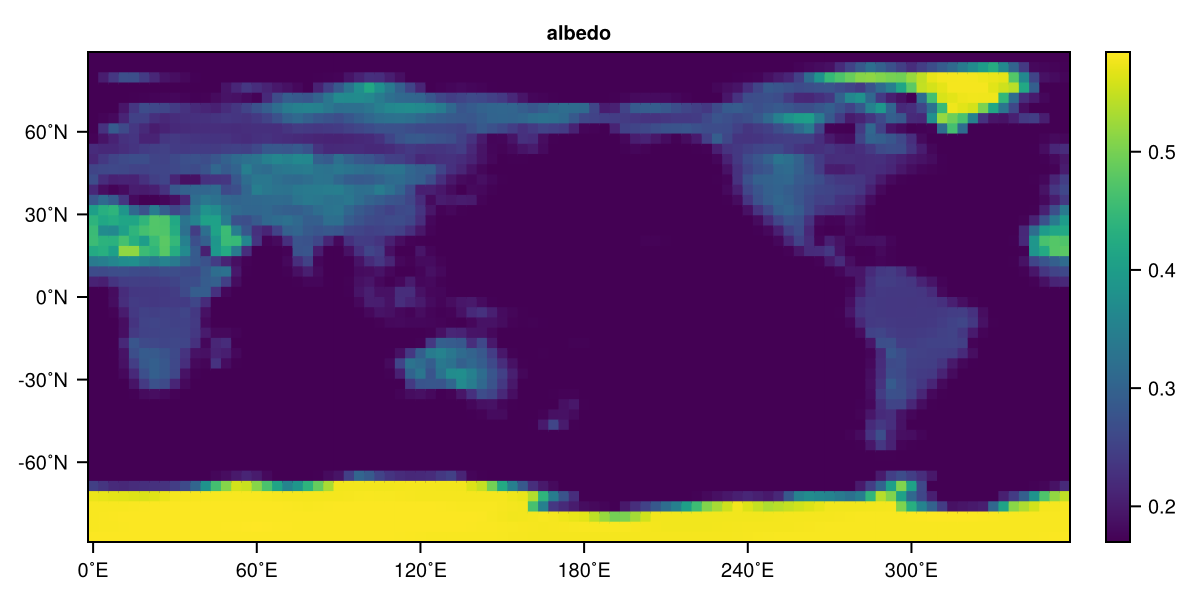

In [18]:
alb_land = simulation.diagnostic_variables.physics.land.albedo
heatmap(alb_land, title="albedo")

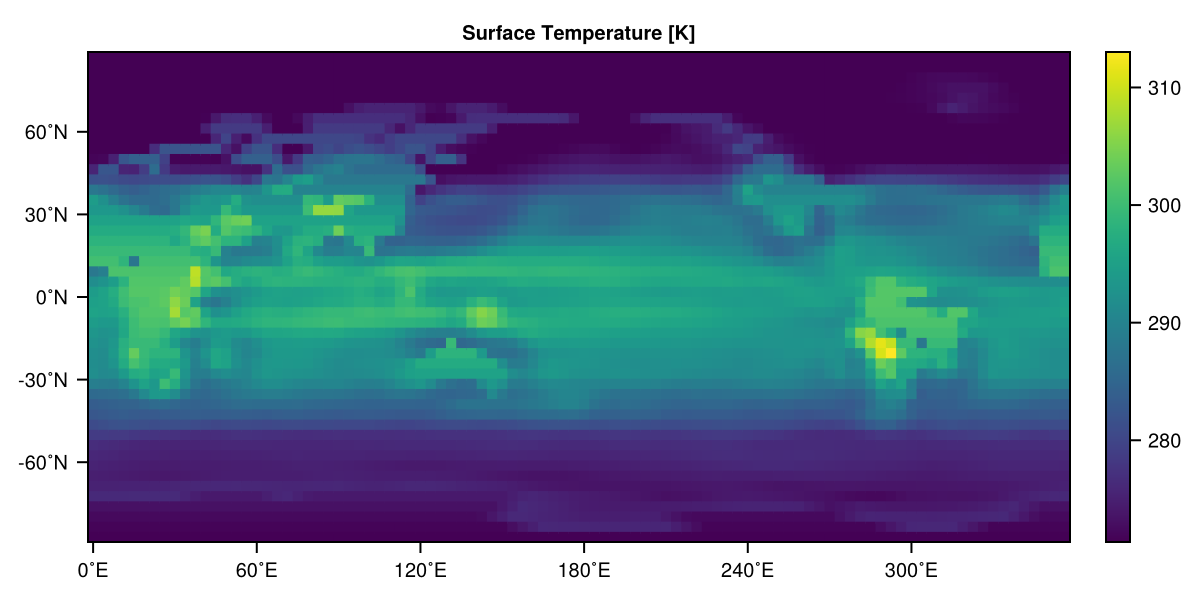

In [19]:
sst = simulation.prognostic_variables.ocean.sea_surface_temperature
heatmap(sst, title="Surface Temperature [K]")

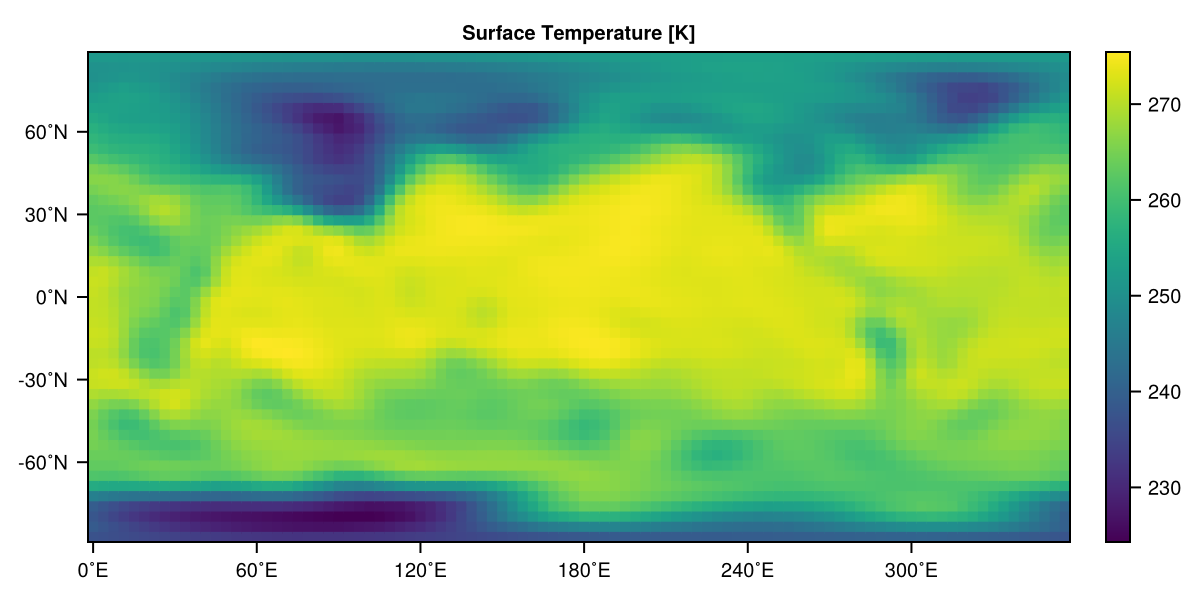

In [20]:
T = simulation.diagnostic_variables.grid.temp_grid[:, 8]
heatmap(T, title="Surface Temperature [K]")

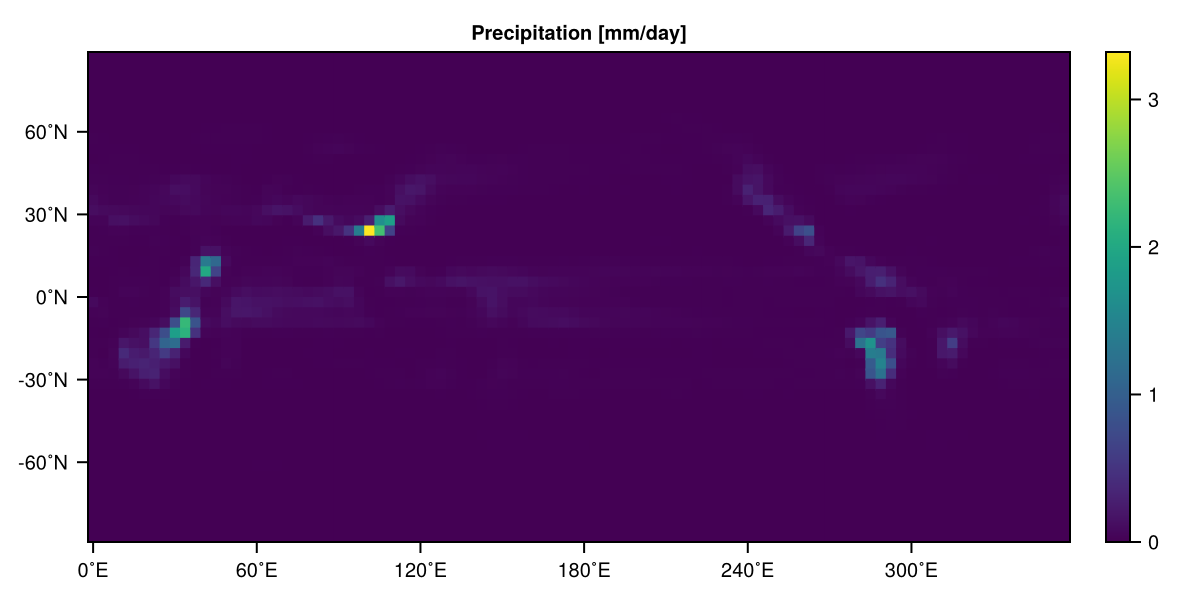

In [21]:
P = simulation.diagnostic_variables.physics.rain_large_scale
heatmap(P, title="Precipitation [mm/day]")

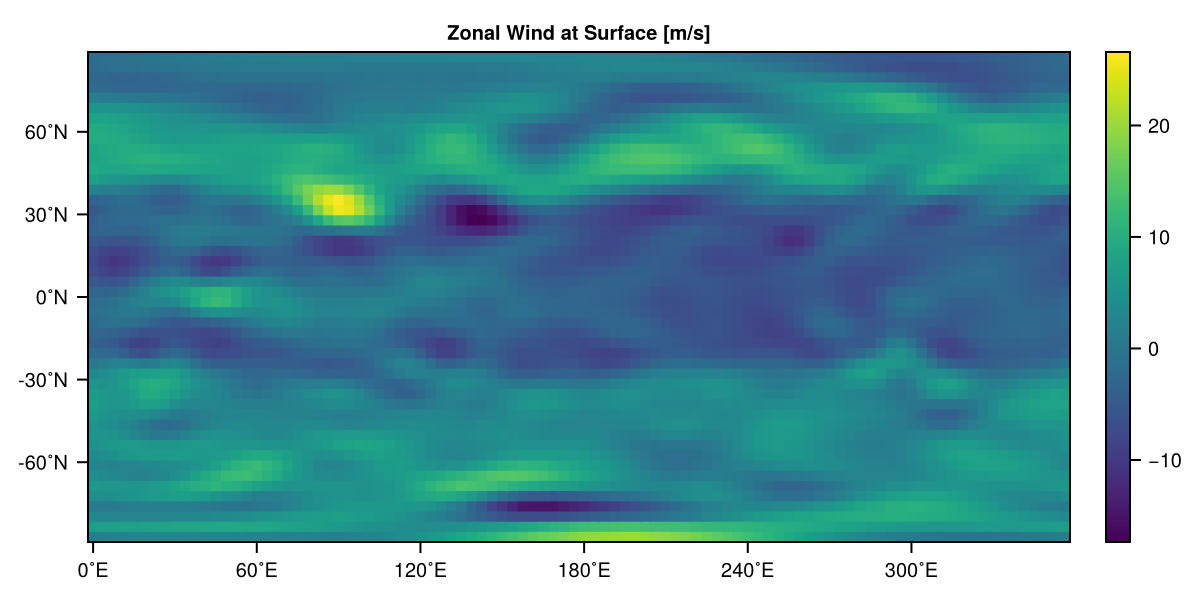

In [22]:
U = simulation.diagnostic_variables.grid.u_grid[:, 8]
heatmap(U, title="Zonal Wind at Surface [m/s]")

## 🧪 Optional Extension: Latitude-Dependent Ocean Albedo
If you’d like to explore more advanced or idealized configurations, you can experiment with latitude-dependent ocean albedo. This allows you to study how spatial patterns in reflectivity influence climate responses.

**🔹 Control Run (Typical Ocean Albedo):**
Set a typical global ocean albedo with a slight increase toward the poles:

`set!(albedo.ocean.albedo_ocean, (λ, φ) -> 0.06 + 0.04 * abs(φ)/90)`.

**🔸 Perturbed Run (Higher Ocean Albedo)**
Now increase the ocean albedo uniformly to examine its impact:

`set!(albedo.ocean.albedo_ocean, (λ, φ) -> 0.16 + 0.04 * abs(φ)/90)`. 


**🔧 How to Enable Latitude-Dependent Albedo**

Replace the default albedo setup with a manual specification:

`# 1. Create a ManualAlbedo object`

`manual = ManualAlbedo(spectral_grid)`



`# 2. Create a composite albedo object:`

`#    - Use the manual setup for ocean`

`#    - Keep the default climatology for land`

`albedo = Albedo(ocean=manual, land=AlbedoClimatology(spectral_grid))`

Then, after initializing your model:

`simulation = initialize!(model)`

`# 3. Set your desired latitudinal pattern for ocean albedo`

`#    (φ is latitude in radians)`

`set!(albedo.ocean.albedo_ocean, (λ, φ) -> 0.06 + 0.04 * abs(φ)/90)`